# Informal tests of both GloVe implementations

The `tensorflow` and `numpy` implementations of GloVe encode the same objective and use the same optimizer and so should arrive at equivalently-good solutions (identical up to randomness). This notebook tests that assumption.

## Imports and prep

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import euclidean

import mittens.tf_mittens as tfm
import mittens.np_mittens as npm

### General test settings

In [4]:
n_words = 500
embedding_dim = 50
max_iter = 1000

### Random symmetric count matrix (GloVe input)

In [5]:
def make_word_word_matrix(n=50):
    """Returns a symmetric matrix where the entries are drawn from an
    exponential distribution"""
    base = np.random.exponential(1.5, size=(n, n)) / 2
    return np.floor(base + base.T)


In [6]:
X = make_word_word_matrix(n_words)

### Correlation test

We expect GloVe models to achieve a high correlation between the dot product of the learned vectors $w_{i}$ and $w_{j}$ and the probability of co-occurrence of words $i$ and $j$. This tests the extent to which that is true:

In [7]:
def correlation_test(true, embeddings):
    """Tests the extent to which the pairwise dot-product of vectors
    in `pred` are proportional to the log of the corresponding cell
    counts in `true` (ignoring 0s, in accord with the GloVe objective).
    """
    true[true > 5] = 5
    nonzero = true > 0
    M = embeddings.dot(embeddings.T)
    true_sums = true.sum(axis=1)
    row_sums = np.repeat(true_sums[:, np.newaxis], len(true_sums), axis=1)
    col_sums = np.repeat(true_sums[np.newaxis, :], len(true_sums), axis=0)
    vs_cooccurrence = np.corrcoef(np.log(true[nonzero]), 
                                  M[nonzero])[0, 1]
    vs_prob = np.corrcoef(np.log(true[nonzero]) + np.log(col_sums[nonzero]), 
                          M[nonzero])[0, 1]
    vs_pmi = np.corrcoef(np.log(true[nonzero]) + np.log(col_sums[nonzero]) + np.log(row_sums[nonzero]), 
                          M[nonzero])[0, 1]
    print("Cooccurrence: {:0.4f} | Prob: {:0.4f} | PMI: {:0.4f}".format(vs_cooccurrence, vs_prob, vs_pmi))
    return vs_cooccurrence, vs_prob, vs_pmi

## Tests

In [8]:
def convergence_plot(np_version, tf_version):
    plt.figure(figsize=(8,5))
    xx = np.log([1 + v for v in range(len(np_version.errors))])
    plt.plot(xx, np.log(np_version.errors))
    plt.plot(xx, np.log(tf_version.errors))
    plt.ylabel("Log error")
    plt.xlabel("Log Epoch")
    plt.legend(['Numpy', 'Tensorflow'])
    plt.show()

### GloVe convergence

In [9]:
npglove = npm.GloVe(n=embedding_dim, max_iter=max_iter, xmax=5)
npG = npglove.fit(X)
_ = correlation_test(X, npG)

Iteration 1000: error 3728.9574

Cooccurrence: 0.4829 | Prob: 0.4830 | PMI: 0.4831


In [10]:
tfglove = tfm.GloVe(n=embedding_dim, max_iter=max_iter, xmax=5)
tfG = tfglove.fit(X)
_ = correlation_test(X, tfG)

Iteration 1000: loss: 3650.55859375525

Cooccurrence: 0.4726 | Prob: 0.4723 | PMI: 0.4721


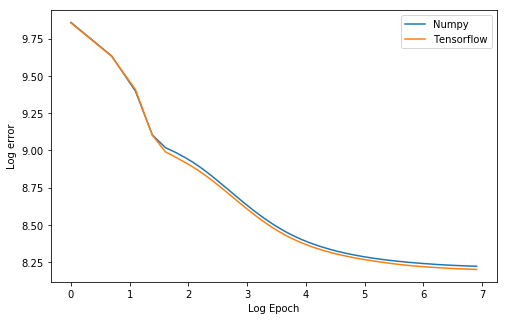

In [11]:
convergence_plot(npglove, tfglove)

### Modified GloVe

For modified GloVe models, we start with representations for a subset of the words.

In [12]:
vocab = ['w_{}'.format(i) for i in range(n_words)]

X_df = pd.DataFrame(X, index=pd.Index(vocab), columns=vocab)

In [13]:
val = 2 * np.sqrt(6 / (n_words + embedding_dim))
EMBEDDING = {w: np.random.uniform(-val, val, size=embedding_dim)
             for w in random.sample(vocab, int(n_words*0.5))}                       

For these models, we want the resulting vectors to be closer on average to the starting point for vectors with initial embeddings than those without such warm starting points. We don't guarantee this for the warm start, but the objective function includes such a term for Mittens.

In [14]:
def get_warm_distances(warm_glove, G_warm, verbose=True, n_words=n_words, EMBEDDING=EMBEDDING):
        
    warm_dists = defaultdict(list)
    warm_start = warm_glove.G_start
    try:
        warm_orig = warm_glove.sess.run(warm_glove.original_embedding)
    except AttributeError:
        warm_orig = warm_glove.original_embedding
    for i in range(n_words):        
        if "w_{}".format(i) in EMBEDDING:                
            dist = euclidean(warm_orig[i], G_warm[i])
            warm_dists['warm'].append(dist)
        else:
            dist = euclidean(warm_start[i], G_warm[i])
            warm_dists['not-warm'].append(dist)
            
    warm_mean = np.mean(warm_dists['warm'])    
    not_warm_mean = np.mean(warm_dists['not-warm'])
    
    if verbose:
        print("Warm mean distance: {}".format(warm_mean))
        print("Not warm mean distance: {}".format(not_warm_mean))

    return warm_dists

### Warm start

In [15]:
tf_warm_glove = tfm.Mittens(n=embedding_dim, max_iter=max_iter, mittens=0)
G_warm = tf_warm_glove.fit(X, vocab=vocab, initial_embedding_dict=EMBEDDING)
warm_dists = get_warm_distances(tf_warm_glove, G_warm)

Iteration 1000: loss: 388.7316589355469

Warm mean distance: 2.5804762358665467
Not warm mean distance: 2.6499979329729637


In [16]:
np_warm_glove = npm.Mittens(n=embedding_dim, max_iter=max_iter, mittens=0)
G_warm = np_warm_glove.fit(X, vocab=vocab, initial_embedding_dict=EMBEDDING)
warm_dists = get_warm_distances(np_warm_glove, G_warm)

Iteration 1000: error 387.7476

Warm mean distance: 2.5988117011544256
Not warm mean distance: 2.6482432461004355


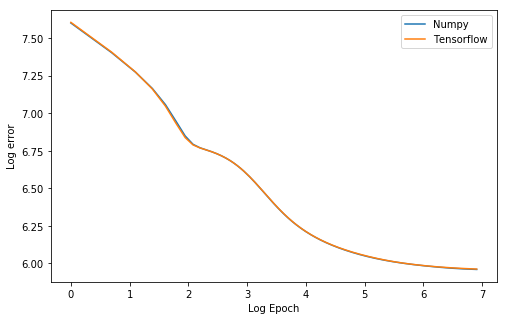

In [17]:
convergence_plot(np_warm_glove, tf_warm_glove)

## Mittens with weights 1

In [18]:
tf_mittens = tfm.Mittens(n=embedding_dim, max_iter=1000, mittens=1)
G_mittens = tf_mittens.fit(X, vocab=vocab, initial_embedding_dict=EMBEDDING)
warm_dists = get_warm_distances(tf_mittens, G_mittens)
_ = correlation_test(X, G_mittens)

Iteration 1000: loss: 455.6892089843755

Warm mean distance: 0.11217507693171501
Not warm mean distance: 2.0389575293353337
Cooccurrence: 0.1407 | Prob: 0.1393 | PMI: 0.1379


In [19]:
np_mittens = npm.Mittens(n=embedding_dim, max_iter=1000, mittens=1, display_progress=10)
G_mittens = np_mittens.fit(X, vocab=vocab, initial_embedding_dict=EMBEDDING) #, W=W, C=C, bw=bw, bc=bc)
warm_dists = get_warm_distances(np_mittens, G_mittens)
_ = correlation_test(X, G_mittens)

Iteration 1000: error 455.6794

Warm mean distance: 0.11047041923313385
Not warm mean distance: 2.050256601458261
Cooccurrence: 0.1308 | Prob: 0.1289 | PMI: 0.1272


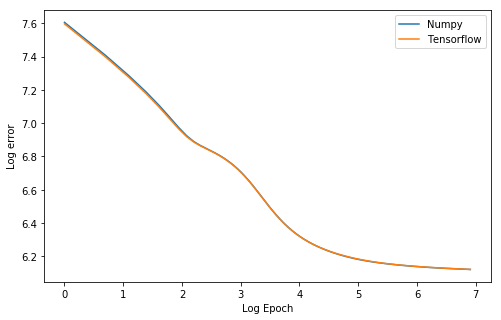

In [20]:
convergence_plot(np_mittens, tf_mittens)